 # (Continue) Pretraining a GET Model on MCF-7 ATAC


 This tutorial demonstrates how to train a GET model to predict ATAC-seq peaks using motif information. We'll cover:

 1. Loading and configuring the model

 2. Training without a pretrained checkpoint

 3. Training with a pretrained checkpoint

 4. Comparing the results



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [8]:
#%%
from get_model.config.config import load_config, pretty_print_config
from get_model.run_region import run_zarr as run

/opt/conda/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


 ## Configuration



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial.yaml`

 This has been altered to allow for multiple zarr directories.

### Training on all Chromsomes
First pass with all chromosomes. 
The trainer cannot register individual chromsomes or ATAC_only. It requres both

In [9]:
import os

# Define the list of chromosomes (excluding X/Y)
# chromosomes_for_modeling = [f"chr{i}" for i in range(1, 23)]  # chr1 to chr22

# Define the base directory where Zarr files are stored
# zarr_base_dir = "./motif_zarr_output_ATAC_only"

# Load the altered config that will allow for multiple zarr datasets (directories)
cfg = load_config('finetune_tutorial')

# Collect all valid Zarr directories (one per chromosome)
# cfg.dataset.zarr_dir = [f"{zarr_base_dir}/{chrom}.zarr" for chrom in chromosomes_for_modeling if os.path.exists(f"{zarr_base_dir}/{chrom}.zarr")]

cfg.dataset.zarr_path = "/project/home/p200469/get_BIO1018/get_preprocess_output.zarr/"
cfg.dataset.celltypes = "all_chrs"

# Set a unique project name for training on all chromosomes
cfg.run.project_name = 'pretrain_all_chrs'

# Include all chromosomes in training (None means no chromosomes are left out)
cfg.dataset.leave_out_chromosomes = None  

# Enable or disable logging
cfg.run.use_wandb = True  

# Training settings
cfg.training.epochs = 50  # Number of training epochs
cfg.training.val_check_interval = 1.0  # Validate after each epoch

# Print statements for debugging
print("Configuration Loaded Successfully!")
print(f"Using Zarr path: {cfg.dataset.zarr_path}")
print(f"Project Name: {cfg.run.project_name}")

Configuration Loaded Successfully!
Using Zarr path: /project/home/p200469/get_BIO1018/get_preprocess_output.zarr/
Project Name: pretrain_all_chrs


 ### Model Selection


 We'll use the GETRegionPretrain model, which is designed to use contextual motif(+atac) information to target motif(+atac) information

 This model is particularly useful for understanding the relationship between motifs and chromatin accessibility.

In [10]:
#%%
# Switch model to finetune ATAC model
cfg.model = load_config('model/GETRegionPretrain').model.model
cfg.dataset.mask_ratio = 0.5 # mask 50% of the motifs. This has to be set for pretrain dataloader to generate proper mask

 ## Training Without Pretraining Checkpoint



 First, let's train the model from scratch (without using a pretrained checkpoint).

 This will give us a baseline for comparison.

wandb: Currently logged in as: faithogun (faithogun-royal-college-of-surgeons-ireland-rcsi-). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']


100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /project/home/p200469/get_BIO1018/get_ML_output/pretrain_all_chrs/pretrain_MCF7_scratch/checkpoints exists and is not empty.


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']


Sanity Checking: |                                                                     | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=25). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
masked_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
masked_pearson,▁▅▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇████████████████
masked_r2,▁▇██████████████████████████████████████
train_loss,█▄▄▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
train_masked_loss,█▄▄▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_masked_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
masked_mse,0.00439


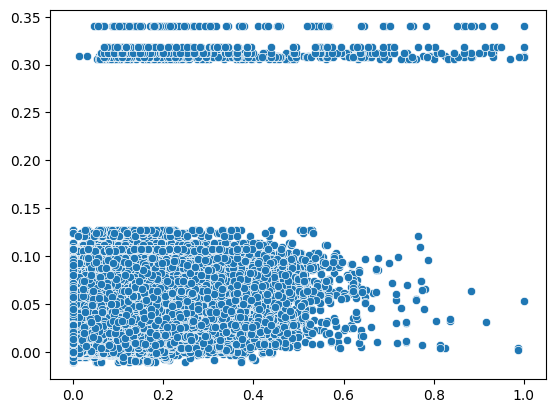

In [4]:
#%%
#Tell machine output directory
cfg.machine.output_dir = "/project/home/p200469/get_BIO1018/get_ML_output"

# first run the model without initializing with a pretrain checkpoint
cfg.run.run_name='pretrain_MCF7_scratch' # this is a unique name for this run
cfg.finetune.checkpoint = None
cfg.finetune.use_lora = False
cfg.run.use_wandb = True
trainer = run(cfg)

In [5]:
#%%
trainer.callback_metrics

{'train_masked_loss': tensor(0.0045),
 'train_loss': tensor(0.0045),
 'val_masked_loss': tensor(0.0044),
 'masked_pearson': tensor(0.3839),
 'masked_mse': tensor(0.0044),
 'masked_r2': tensor(0.1439),
 'val_loss': tensor(0.0044)}

 ## Continue Training With Pretrained Checkpoint Using LoRA



 Now, let's train the model using a pretrained checkpoint. This checkpoint was trained on a large dataset

 and should help the model learn faster and potentially achieve better performance.



 Note: You'll need to download the checkpoint first:

In [ ]:
#Download pulbic checkpoint file

!curl -O https://2023-get-xf2217.s3.amazonaws.com/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/pretrain_fetal_adult/checkpoint-799.pth

Load ckpt from ./checkpoint-799.pth
Load state_dict by model_key = model


wandb: Currently logged in as: faithogun (faithogun-royal-college-of-surgeons-ireland-rcsi-). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.69it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']


100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.10it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']


Sanity Checking: |                                                                     | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=25). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
masked_mse,█▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
masked_pearson,▁▆▇▇▇▇▇▇▇████▇█▇██▇█▇█████████▇█████████
masked_r2,▁▇▇▇▇█████████████▇█▇███████████████████
train_loss,█▃▃▂▂▂▃▂▁▂▂▂▂█▂▃▃▃▂▂▂▂▁▂▂▂▂▂▆▂▂▁▂▃▃▂▁▂▂▃
train_masked_loss,█▃▃▂▂▂▃▂▁▂▂▂▂█▂▃▃▃▂▂▂▂▁▂▂▂▂▂▆▂▂▁▂▃▃▂▁▂▂▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
val_loss,█▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_masked_loss,█▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
masked_mse,0.00431


{'train_masked_loss': tensor(0.0049),
 'train_loss': tensor(0.0049),
 'val_masked_loss': tensor(0.0043),
 'masked_pearson': tensor(0.3972),
 'masked_mse': tensor(0.0043),
 'masked_r2': tensor(0.1566),
 'val_loss': tensor(0.0043)}

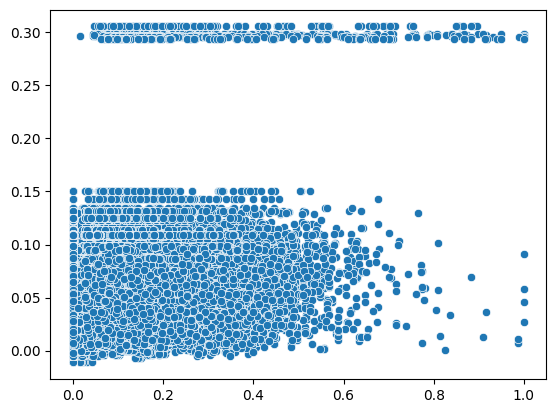

In [12]:
#%%
# now train the model with a pretrain checkpoint

cfg.machine.output_dir = "/project/home/p200469/get_BIO1018/get_ML_output"
cfg.finetune.checkpoint = './checkpoint-799.pth'
cfg.run.run_name = 'pretrain_mcf7_from_pretrain_lora'
cfg.finetune.model_key = "model"
cfg.finetune.rename_config = {
  "encoder.head.": "head_mask.",
  "encoder.region_embed": "region_embed",
  "region_embed.proj.": "region_embed.embed.",
  "encoder.cls_token": "cls_token",
}
cfg.finetune.strict = True
cfg.finetune.use_lora = True
cfg.finetune.layers_with_lora = ['region_embed', 'encoder']
trainer = run(cfg)
trainer.callback_metrics

/opt/conda/lib/python3.12/site-packages/get_model/utils.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu")


Load ckpt from ./checkpoint-799.pth
Load state_dict by model_key = model


100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.92it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']


100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX']


Sanity Checking: |                                                                     | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=25). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                            | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

Validation: |                                                                          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
masked_mse,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
masked_pearson,▁▄▅▅▅▆▆▆▇▇▇▆▇▇▇▆▇▇▇▇▇██▇▆▇▇█▇██▇██████▇█
masked_r2,▁▆▇█▇███████████████████████████████████
train_loss,█▄▁▂▃▂▃▂▄▂▂▂▂▁▃▂▂▂▃▂▂▁▂▂▂▂▁▂▂▂▁▂▂▁▂▂▂▂▂▂
train_masked_loss,█▄▁▂▃▂▃▂▄▂▂▂▂▁▃▂▂▂▃▂▂▁▂▂▂▂▁▂▂▂▁▂▂▁▂▂▂▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
val_loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_masked_loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,49
masked_mse,0.0043


{'train_masked_loss': tensor(0.0045),
 'train_loss': tensor(0.0045),
 'val_masked_loss': tensor(0.0043),
 'masked_pearson': tensor(0.3986),
 'masked_mse': tensor(0.0043),
 'masked_r2': tensor(0.1582),
 'val_loss': tensor(0.0043)}

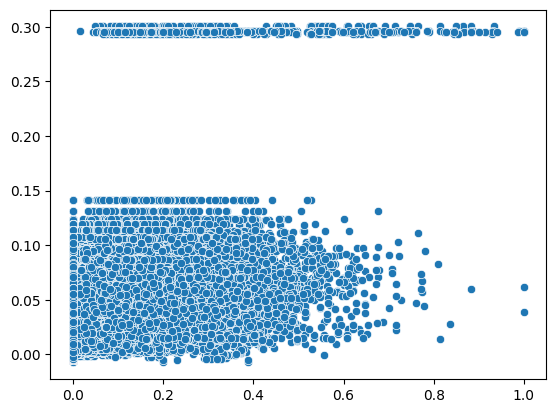

In [13]:
#%%
# now train the model with a pretrain checkpoint without using LoRA
cfg.finetune.checkpoint = './checkpoint-799.pth'
cfg.run.run_name = 'pretrain_mcf7_from_pretrain_no_lora'
cfg.finetune.use_lora = False
trainer = run(cfg)
trainer.callback_metrics